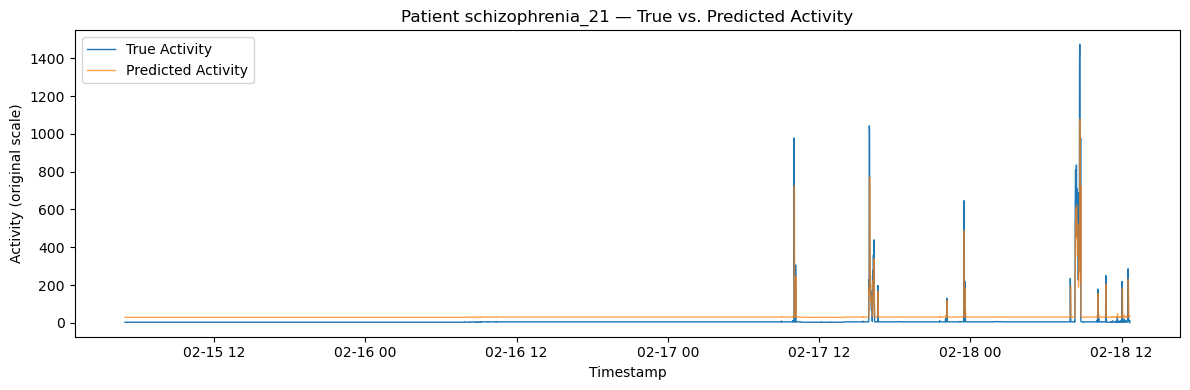

In [11]:
import random
import matplotlib.pyplot as plt
from joblib import load, dump
from sklearn.linear_model import LinearRegression


X_train, y_train, t_train = load('train_set.joblib')
X_test,  y_test,  t_test  = load('test_set.joblib')


activity_scaler = load('activity_scaler.joblib')


reg = LinearRegression()
reg.fit(X_train.drop(columns=['patient_id']), y_train)
dump(reg, 'reg_model.joblib')


pid  = random.choice(X_test['patient_id'].unique())
mask = X_test['patient_id'] == pid

X_pid          = X_test[mask].drop(columns=['patient_id'])
y_true_scaled  = y_test[mask].values.reshape(-1,1)
times          = t_test[mask]


y_pred_scaled = reg.predict(X_pid).reshape(-1,1)


y_true = activity_scaler.inverse_transform(y_true_scaled).flatten()
y_pred = activity_scaler.inverse_transform(y_pred_scaled).flatten()


plt.figure(figsize=(12, 4))
plt.plot(times, y_true, label='True Activity',     linewidth=1)
plt.plot(times, y_pred, label='Predicted Activity', linewidth=1, alpha=0.7)
plt.title(f'Patient {pid} — True vs. Predicted Activity')
plt.xlabel('Timestamp')
plt.ylabel('Activity (original scale)')
plt.legend()
plt.tight_layout()
plt.show()


In [12]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd
from joblib import load


reg       = load('reg_model.joblib')
X_test, y_test, t_test = load('test_set.joblib')


activity_scaler = load('activity_scaler.joblib')


X_feat         = X_test.drop(columns=['patient_id'])
y_pred_scaled  = reg.predict(X_feat).reshape(-1,1)
y_true_scaled  = y_test.values.reshape(-1,1)


y_pred = activity_scaler.inverse_transform(y_pred_scaled).flatten()
y_true = activity_scaler.inverse_transform(y_true_scaled).flatten()


df_eval = pd.DataFrame({
    'patient_id': X_test['patient_id'],
    'y_true':     y_true,
    'y_pred':     y_pred
})


metrics = []
for pid, grp in df_eval.groupby('patient_id'):
    rmse = np.sqrt(mean_squared_error(grp['y_true'], grp['y_pred']))
    mae  = mean_absolute_error(grp['y_true'], grp['y_pred'])
    metrics.append({'patient_id': pid, 'rmse': rmse, 'mae': mae})

df_metrics = pd.DataFrame(metrics)


mean_rmse = df_metrics['rmse'].mean()
mean_mae  = df_metrics['mae'].mean()

print(f"Mean RMSE across patients: {mean_rmse:.4f}")
print(f"Mean MAE  across patients: {mean_mae:.4f}")


Mean RMSE across patients: 106.7258
Mean MAE  across patients: 68.5046
